# Overseeing government with AI - ICEDEG 2023 tutorial


Copyright (C) 2023  [Henrique S. Xavier](https://github.com/hsxavier)

This notebook is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This notebook is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this notebook.  If not, see <https://www.gnu.org/licenses/>.


## 1. The goal of the tutorial

Overseeing government may demand a lot of work. Monitoring the Brazilian Government Gazette in search of high impact decisions, for instance, requires reading many hundreds of legal notices every day. In this scenario, a filtering tool that select potentially relevant notices for human scrutiny might come in handy. This tutorial goes through the process of creating such a tool using machine learning, and is based on a successful implementation made by the Brazilian Congress since 2020.

## 2. Machine Learning basics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import auxiliary as aux

### 2.1. How patterns on data are learnt by computers

#### 2.1.1. Binary classification (yes/no): is this mango tasty?

Pretend we are trying to learn to guess if a mango is tasty or not based on its color and consistency. We will measure the color and the consistency in scales from 0 to 1. The actual tastyness is defined by the function below:

In [5]:
def tastyness(color, consist, noise=0):
    """
    Return 0 or 1 if a mango is tasty or not according
    to its color and consistency. The introduction of
    noise makes the relation a bit fuzzy (intrinsically
    uncertain).47
    """
    
    # Generate intrinsic noise, if any:
    rng = np.random.default_rng()
    e = noise * rng.normal(size=(4, len(color)))
    
    # Decide whether the mango is trully tasty or not:
    tasty = ((color + e[0] > 0.2) & (color + e[1] < 0.8) & (consist + e[2] > 0.3) & (consist + e[3] < 0.7)).astype(int)
    
    return tasty

To learn about this relation between tastyness and color and consistency, we select a sample of mangos _that is representative of the mangos we will find later on_:

In [112]:
# Reset simulation with given parameters:
n_samples = 30
seed = 45864
intrinsic = 0.0  # You can try 0.05, for instance.

# Record the first generated data:
rng = np.random.default_rng(seed)
x   = rng.random(n_samples)
y   = rng.random(n_samples)
z   = tastyness(x, y, intrinsic)
xp  = x[z == 1]
yp  = y[z == 1]
xn  = x[z == 0]
yn  = y[z == 0]
rng = np.random.default_rng(seed)

The code below selects a set of mangos. Each time you run it, you are selecting another (and different) set.

In [115]:
# Generate data sample:
color1   = rng.random(n_samples)
consist1 = rng.random(n_samples)
tasty1   = tastyness(color1, consist1, intrinsic)

Below, we create a scatter plot of the mangos, where the color of the points tell if the mango is tasty or not (assume that orange means tasty). We also draw a boundary that we use to discriminate the good from the bad mangos, _guessed from the first set of 30 mangos we see_. You may select five different boundaries, _all of which perfectly splits the first set of analyzed mangos into tasty and not tasty_. However, if we select a new set of mangos, the success of each boundary is different.

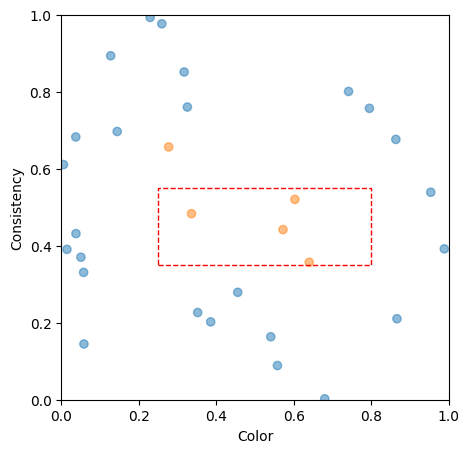

In [118]:
# Plot data:
cmap = pl.get_cmap('tab10')
pl.figure(figsize=(5,5))
pl.scatter(color1, consist1, alpha=0.5, color=cmap(tasty1))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('Color')
pl.ylabel('Consistency')
ax = pl.gca()

# Draw decision boundary (choose one):
guess = PatchCollection([patches.Rectangle((0.25, 0.35), 0.55, 0.2)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection([patches.Rectangle((0.09, 0.3), 0.72, 0.48)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection([patches.Ellipse((0.5, 0.5), 0.7, 0.35, angle=-15)], edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection(aux.multicircles(xp, yp), edgecolor='r', linestyle='--', facecolor='none')
#guess = PatchCollection(aux.multicircles(xn, yn), edgecolor='r', linestyle='--', facecolor='none')
ax.add_collection(guess)

pl.show()

Do the following experiments, combining them in multiple ways:

* Try **selecting a new set of mangos** and seeing how our boundary discriminates good and bad mangos.
* Try **changing the decision boundary** for identifying tasty mangos. How does this affect the two errors (false positives and false negatives)?
* Try **increasing the sample size** and seeing if you can better see the pattern in mango tastiness.
* Try **adding intrinsic noise** to the relation between tastyness and color and consistency. Would you be able to set a boundary that perfectly splits the mangos into good and bad?

#### 2.1.2. Regression (predict values): number of active users at a given time of the day

Suppose we want the predict the number of active users on an online platform according to the time of the day. 
The actual number of users at a given time depends on many other factors we cannot measure; therefore, it is treated 
as a random number that fluctuates around the expected value given by the function below.

In [5]:
def active_users(hour):
    """
    Compute the expected number of active users per time 
    of the day (hour from 0 to 24).
    """  
    x = hour
    y = (np.sin(2*np.pi / 24 * 3 * (x - 5)) - 0.015 * (x - 12)**2 + 4 * np.exp(-(x-20)**2*0.4) + 3) * 15

    return y

We are busy people, so we cannot keep an eye on the number of users all the time. To learn about the relation above, we go through a week collecting data when we can (at random times) by writing down the time of the day and the number of active people. The code below defines the amount of data collected each week.

In [159]:
# Reset simulation with given parameters:
n_samples = 32
seed      = 363

# Record the first data that will be generated:
rng = np.random.default_rng(seed)
x0  = rng.random(n_samples) * 24
y0  = rng.poisson(active_users(x0))
rng = np.random.default_rng(seed)

This data is generated by the code below. Each time we run it is another week we collected new data (starting with the first week):

In [156]:
# Generate data sample:
hour  = rng.random(n_samples) * 24
#hour  = np.linspace(0,24, n_samples)
users = rng.poisson(active_users(hour))

To the dataset collected in the first week, we fit a polynomial model with a degree that we can choose. By increasing the polynomial degree, 
we can make the model reproduce [almost any function](https://en.wikipedia.org/wiki/Taylor_series). Thus, in this way, the model can become more and more flexible (complex).

In [157]:
# Fit model to the first data:
degree = 13
model = Pipeline([('poly', PolynomialFeatures(degree)), ('scal', StandardScaler()), ('reg', LinearRegression())])
dump = model.fit(np.transpose([x0]), y0)

The plot below shows the data collected in the first week (in empty pink circles), the last dataset collected (blue filled circles) and the polynomial model fitted to the data from the first week (red line). In text, it is also shown the model's average error (RMSE) computed for the first dataset (used to fit the model) and for the last data collected.

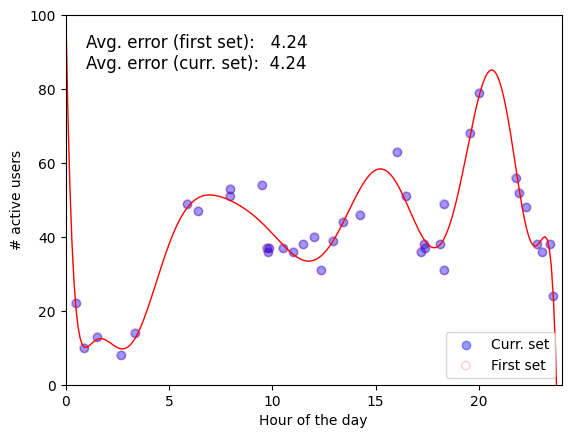

In [158]:
# Plot the first dataset and the last data collected:
pl.scatter(hour, users, color='b', alpha=0.4, label='Curr. set')
pl.scatter(x0, y0, edgecolor='r', facecolor='none', alpha=0.2, label='First set')

# Drawn curve representing the fit:
x_fit = np.arange(0, 24, 0.1)
y_fit = model.predict(np.transpose([x_fit]))
pl.plot(x_fit, y_fit, color='r', linewidth=1)

# Compute the error on the first data:
y0_pred = model.predict(np.transpose([x0]))
err0 = mean_squared_error(y0, y0_pred, squared=False)
# Compute the error on the new data:
pred_users = model.predict(np.transpose([hour]))
err_pred = mean_squared_error(users, pred_users, squared=False)
# Show the errors:
pl.text(1, 80, 'Avg. error (first set):  {:5.2f}\nAvg. error (curr. set): {:5.2f}\n'.format(err0, err_pred), ha='left', fontsize=12)

# Format the plot:
pl.xlim([0,24])
pl.ylim([0, 100])
pl.xlabel('Hour of the day')
pl.ylabel('# active users')
pl.legend(loc='lower right')
pl.show()

Do the following experiments, combining them in multiple ways:

* **Collect new data.** How does the model's predictions compare to the data used to fit it? And to the new data? Remember that the prediction error is measured by the vertical distance between the datapoint and the line. Check the average error as well.
* **Change the model's flexibility** by changing the polynomial degree. Does this improve the model's fit to the first data? What about to the new data (not used to train the model)?
* **Change the amount of collected data**. How does this affect the model and its performance on the seen and unseen data?

The code below fits polynomial models with different flexibilities to the training data and tests it on both datasets generated above. The results are shown in a plot. It should reflects our findings from the experiments made above.

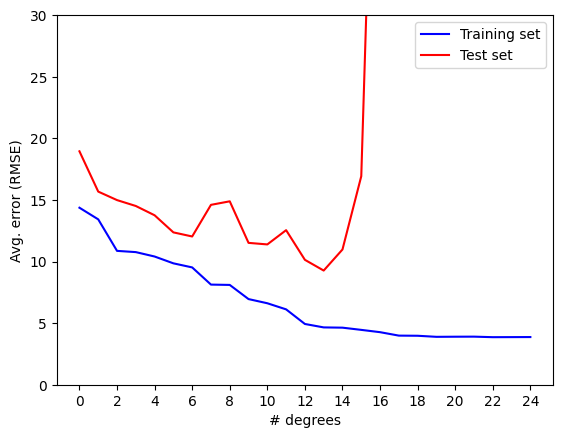

In [32]:
train_rmse = []
test_rmse  = []
max_deg    = min(n_samples, 25)
deg_list   = list(range(0, max_deg))
for deg in deg_list:
    
    # Instantiate model with a given polynomial degree and fit to the training (first) data:
    m = Pipeline([('poly', PolynomialFeatures(deg)), ('scal', StandardScaler()), ('reg', LinearRegression())])
    m.fit(np.transpose([x0]), y0)
    
    # Compute error for the training data:
    y_pred = m.predict(np.transpose([x0]))
    err = mean_squared_error(y0, y_pred, squared=False)
    train_rmse.append(err)
    
    # Compute error for the test (new) data:
    y_pred = m.predict(np.transpose([hour]))
    err = mean_squared_error(users, y_pred, squared=False)
    test_rmse.append(err)

pl.plot(deg_list, train_rmse, color='b', label='Training set')
pl.plot(deg_list, test_rmse, color='r', label='Test set')
pl.ylim([0, 30])
pl.xticks(range(0, max_deg, 2))
pl.xlabel('# degrees')
pl.ylabel('Avg. error (RMSE)')
pl.legend()
pl.show()

#### Takeaway messages

**Main ones**
* An increase in the model's flexibility (almost) always leads to a smaller error on the training set.
* An increase in model's flexibility (complexity) leads to more variance (chance of overfitting): the model may have trouble generalizing.
* A decrease, on the contrary, leads to more bias (chance of underfitting): the model cannot learn all there is to be learned.
* More data leads to more information and less variance: we can use more complex models.
* We are looking for the sweet spot where the error on the unseen data is minimum.
* The choice of a sweet spot based on previously unseen data makes it "seen", so the average error estimate is overconfident.
* In the end will use three distinct datasets: training, validation and test sets.

**Extras**
* There are irreducible errors, intrinsic to the data, that limit the perfomance of the model.
* Adding data features acts in a similar way to increasing the flexibility of the model. 
* Different classes of models have different limitations, some might work better than others.

### 2.2. Splitting the data into disjoint sets

In [3]:
from sklearn.svm import SVC

As seen in Section 2.1, ML models can underfit or overfit the data. By comparing the performance on data used to fit the model with the performance on unseen data, we can know in which regime we are. Moreover, since it is the latter performance we are interested in, it can be used to choose the best hyperparameters for the job (in Section 2.1.1, the shape of the decision boundary; and in Section 2.1.2, the degree of the polynomial). This is called **hyperparameter tuning** or **fine tuning**.

Thus, when building an ML model, it is important to split the data into two disjoint datasets, one for fitting (training) the model and another for hyperparameter tuning. Note, however, that, in this situation, the last dataset is not "unseen" anymore: the perfomance of the model on it was used as input for determining the hyperparemeters, which may cause a slight overfit on it. Therefore, it is common practice to split the data into three disjoint datasets:

* **Training set** - Used to fit the model; should be around 70% of the data.
* **Validation set** - Used to improve the model through hyperparameter tuning; should be around 15% of the data.
* **Test set** - Locked in a vault! Only used to get an unbiased measure of the performance when the model is done; should be around 15% of the data.

#### 2.2.1. Problems caused by bad sampling (or splitting) of the dataset

Let's generate some mango data and try some splits.

**Important:** all splits of the dataset above should be representative of the population (i.e. the difference between their target variables should come mostly from noise, that is, from variations that are not predictable by the model), and they should be dispersed all over the feature space (extrapolations are bad). The most common way to achieve this is by random sampling the data.

In [59]:
# Gata generation parameters:
seed       = None
n_samples  = 1200
noise      = 0.08
train_frac = 0.6

# Generate the full dataset:
rng = np.random.default_rng(seed)
color   = rng.random(n_samples)
consist = rng.random(n_samples)
tasty   = tastyness(color, consist, noise) # We did not specify a seed for the noise.

Below we select a subsample of the dataset (e.g. for training the model). 

This first selection is done correctly: the probability that a mango is selected does not depend on any of its properties:

In [60]:
# Unbiased selection - the probability that a mango is selected does not depend on its tastyness:
unbiased_features, unbiased_tasty = aux.biased_random_split((color, consist), tasty, train_frac, 0.0, rng)
unbiased_color, unbiased_consist  = unbiased_features

Probability of adding instance to training set, according to its target label:
label == 1: 60.0%;   label == 0: 60.0%


This next selection, however, favors mangos that are good (which is wrong):

In [61]:
# Biased selection - good mangos are more likely to get selected:
biased_features, biased_tasty = aux.biased_random_split((color, consist), tasty, train_frac, 1.0, rng)
biased_color, biased_consist  = biased_features

Probability of adding instance to training set, according to its target label:
label == 1: 96.3%;   label == 0: 48.1%


Now we compare these two selections with the original dataset and with another wrong selection (that does not cover the whole feature space):

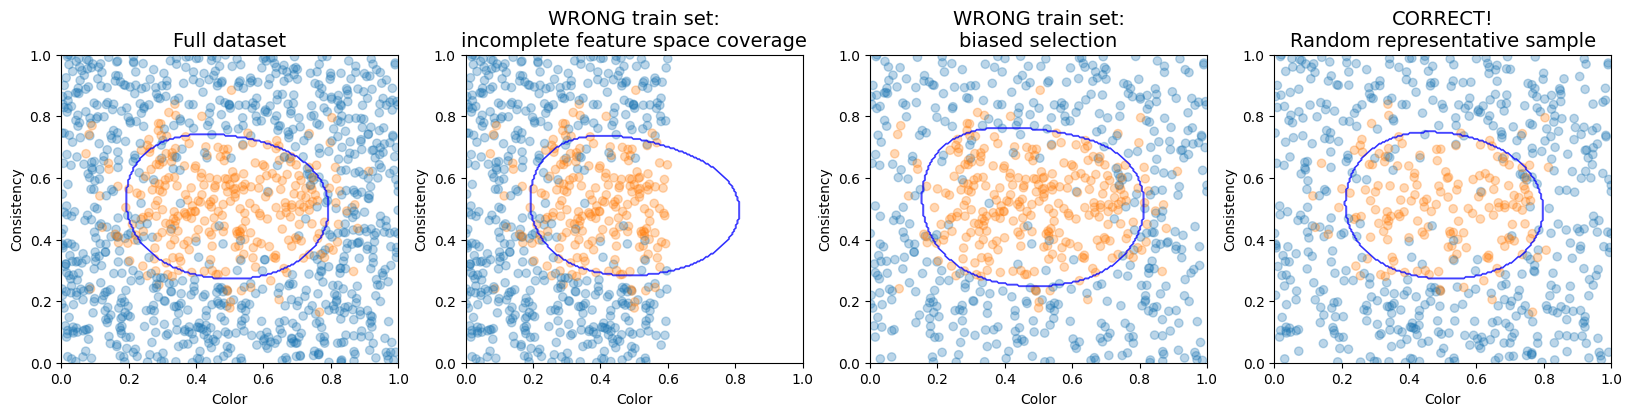

In [62]:
# Set colors and model for drawing the decision boundary:
cmap = pl.get_cmap('tab10')
colors = np.array([cmap(i) for i in tasty])
svc = SVC()

# Data for each plot:
xs = [color, color[color < train_frac], biased_color, unbiased_color]
ys = [consist, consist[color < train_frac], biased_consist, unbiased_consist]
ks = [tasty, tasty[color < train_frac], biased_tasty, unbiased_tasty]
titles = ['Full dataset', 'WRONG train set:\nincomplete feature space coverage', 'WRONG train set:\nbiased selection', 'CORRECT!\nRandom representative sample']

# Create the plots:
pl.figure(figsize=(20,4))
for i, x, y, k, t in zip(range(len(ks)), xs, ys, ks, titles):
    pl.subplot(1, 4, i + 1)
    pl.title(t, fontsize=14)
    # Fit model and plot decision boundary:
    svc.fit(np.transpose([x,y]), k)
    aux.plot_predictions(svc)
    # Plot the data:
    aux.mango_scatter_plot(x, y, k)
    # Plot true boundary:
    #ax = pl.gca()
    #guess = PatchCollection([patches.Rectangle((0.2, 0.3), 0.6, 0.4)], edgecolor='r', linestyle='--', facecolor='none')
    #ax.add_collection(guess)
pl.show()

**Takeaways**

* Extrapolation (predicting the label in regions where you have no data) is a bad idea.
* Be careful to random sample your data: shuffling might be a good idea.
* When collecting data, make sure the it obeys the population (or production) distribution $P(y|X)$.

#### 2.2.2. Effect of inhomogeneous sampling

Question: what happens if the data distribution on the feature space, $P(X)$, is inhomogeneous or different than the population distribution?

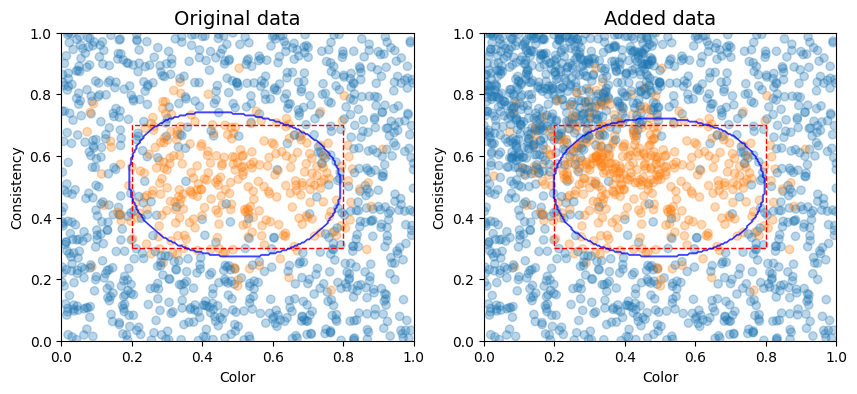

In [64]:
# Put data into a DataFrame:
orig_df  = pd.DataFrame({'color':color, 'consist':consist, 'tasty':tasty})
# Fit model to original data:
orig_svc = SVC()
orig_svc.fit(np.transpose([orig_df['color'], orig_df['consist']]), orig_df['tasty'])

# Generate new data:
color2   = rng.random(n_samples * 2)
consist2 = rng.random(n_samples * 2)
tasty2   = tastyness(color2, consist2, noise) # We did not specify a seed for the noise.
data_df  = pd.DataFrame({'color':color2, 'consist':consist2, 'tasty':tasty2})
# Predict based on new data:
k_pred2  = orig_svc.predict(np.transpose([data_df['color'], data_df['consist']]))
 
# Join old and part of the new data:
concat_df = pd.concat([orig_df, data_df.query('color < 0.5 and consist > 0.5')])
#concat_df = pd.concat([orig_df, data_df.query('consist > 0.8')])
#concat_df = pd.concat([orig_df, data_df.loc[k_pred2 == 1]])

# Plot data and decision boundary:
pl.figure(figsize=(10, 4))
for i, df, t in zip(range(2), [orig_df, concat_df], ['Original data', 'Added data']):
    pl.subplot(1,2, i + 1)
    pl.title(t, fontsize=14)
    # Fit model and plot decision boundary:
    svc.fit(np.transpose([df['color'], df['consist']]), df['tasty'])
    aux.plot_predictions(svc)
    # Plot the data:
    aux.mango_scatter_plot(df['color'], df['consist'], df['tasty'])  
    # Plot true boundary:
    ax = pl.gca()
    guess = PatchCollection([patches.Rectangle((0.2, 0.3), 0.6, 0.4)], edgecolor='r', linestyle='--', facecolor='none')
    ax.add_collection(guess)
pl.show()

Answer: more densely sampled regions of the feature space are better predicted, but no biases are introduced.

#### 2.2.3. Basic random split

In [8]:
from sklearn.model_selection import train_test_split

Let's first generate some data:

In [9]:
# Gata generation parameters:
seed       = None
n_samples  = 10
noise      = 0.08
train_frac = 0.5

# Generate the full dataset:
rng = np.random.default_rng(seed)
color   = rng.random(n_samples)
consist = rng.random(n_samples)
tasty   = tastyness(color, consist, noise) # We did not specify a seed for the noise.

# Build DataFrame:
mango_df = pd.DataFrame({'color':color, 'consist':consist, 'tasty':tasty})

The simplest way to split the data into random disjoint sets is to shuffle the data and then select the first $n_{\mathrm{train}}$ instances as the training set and the remaining instances as the test set. This can be done with the `train_test_split` function, for instance:

In [10]:
# Random split DataFrame:
split_seed = 95033
train_df, test_df = train_test_split(mango_df, train_size=train_frac, random_state=split_seed)

**Important:** Always set the random_state (seed) of the pseudo-random number generator. This will prevent the data from separate sets to get mixed up between runs and will allow for reproducibility.

In [11]:
# Display train dataset:
train_df.sort_index()

,color,consist,tasty
0,0.752791,0.185097,0
1,0.157747,0.817941,0
3,0.008305,0.391188,0
4,0.890426,0.223708,0
7,0.815907,0.721799,0


In [12]:
# Display test dataset:
test_df.sort_index()

,color,consist,tasty
2,0.327651,0.615389,1
5,0.767310,0.810626,0
6,0.360090,0.618369,1
8,0.050358,0.290103,0
9,0.106585,0.767129,0


Let's do the same thing, but using Numpy arrays:

In [13]:
# Random split arrays:
train_color, test_color, train_consist, test_consist, train_tasty, test_tasty = train_test_split(color, consist, tasty, train_size=train_frac, random_state=split_seed)

# First entries of the train set:
print('Train set:')
aux.print_arrays_heads([train_color, train_consist, train_tasty], ['color', 'consist', 'tasty'], 6)

# First entries of the test set:
print('Test set:')
aux.print_arrays_heads([train_color, train_consist, train_tasty], ['color', 'consist', 'tasty'], 6)

Train set:
color:   [0.81590681 0.89042593 0.75279146 0.15774662 0.00830514]
consist: [0.72179869 0.22370768 0.18509745 0.81794138 0.39118801]
tasty:   [0 0 0 0 0]
Test set:
color:   [0.81590681 0.89042593 0.75279146 0.15774662 0.00830514]
consist: [0.72179869 0.22370768 0.18509745 0.81794138 0.39118801]
tasty:   [0 0 0 0 0]


**Important:** this procedure works if your dataset does not get updated between multiple fits. If it does, the data that was in one set (e.g. validation set) 
might get into another (e.g. test set) after more data is added. This would break the "unseeness" of the validation and test data. Let's see an example:

In [14]:
# Add new data:
extra_data_df = pd.DataFrame({'color': [0.666666, 0.999999], 'consist':[0.666666, 0.999999], 'tasty':[1, 0]}, index=[n_samples, n_samples + 1])
added_data_df = pd.concat([mango_df, extra_data_df])
added_data_df

,color,consist,tasty
0,0.752791,0.185097,0
1,0.157747,0.817941,0
2,0.327651,0.615389,1
3,0.008305,0.391188,0
4,0.890426,0.223708,0
5,0.767310,0.810626,0
6,0.360090,0.618369,1
7,0.815907,0.721799,0
8,0.050358,0.290103,0
9,0.106585,0.767129,0


In [15]:
# Split the data with the same seed:
new_train_df, new_test_df = train_test_split(added_data_df, train_size=train_frac, random_state=split_seed)

Compare the entries in the new test set with the previous one. Instances that were in the training set are now in the test set:

In [16]:
new_test_df.sort_index()

,color,consist,tasty
2,0.327651,0.615389,1
4,0.890426,0.223708,0
6,0.360090,0.618369,1
7,0.815907,0.721799,0
8,0.050358,0.290103,0
11,0.999999,0.999999,0


In [17]:
test_df.sort_index()

,color,consist,tasty
2,0.327651,0.615389,1
5,0.767310,0.810626,0
6,0.360090,0.618369,1
8,0.050358,0.290103,0
9,0.106585,0.767129,0


#### 2.2.2. Splitting with a hash function

One way to solve the problem above is to use a [hash function](https://en.wikipedia.org/wiki/Hash_function). We adapted the implementation by [Aurélien Geron](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) to strings:

In [2]:
from zlib import crc32

def hash_string(string, prefix=''):
    """
    Takes a `string` as input, remove `prefix` from it and turns it into a hash.
    """
    name   = string.replace(prefix, '')
    return crc32(bytes(name, 'utf-8'))

def test_set_check_by_string(string, test_frac, prefix=''):
    """
    Returns a boolean array saying if the data identified by `string` belongs to the test set or not.
    
    Parameters
    ----------
    string : str
        The string that uniquely identifies an example.
    test_frac : float
        The fraction of the complete dataset that should go to the test set (0 to 1).
    prefix : str (default '')
        A substring to remove from `string` before deciding where to place the example.
        
    Returns
    -------
    is_test : bool
        A bool number saying if the example belongs to the test set.
    """

    return hash_string(string, prefix) & 0xffffffff < test_frac * 2**32

def train_test_split_by_string(df, test_frac, col, prefix=''):
    """
    Split a DataFrame `df` into train and test sets based on string hashing.
    
    Input
    -----
    
    df : Pandas DataFrame
        The data to split.
        
    test_frac : float
        The fraction of `df` that should go to the test set (0 to 1).

    col : str or int
        The name of the `df` column to use as identifier (to be hashed).
        
    prefix : str (default '')
        A substring to remove from the rows in column `col` of `df` 
        before deciding where to place the example.
        
    Returns
    -------
    
    The train and the test sets (Pandas DataFrames).
    """
    ids = df[col]
    in_test_set = ids.apply(lambda s: test_set_check_by_string(s, test_frac, prefix))
    return df.loc[~in_test_set], df.loc[in_test_set]

Let's see how the hash function works:

In [19]:
# Exploring the hash function:
print(hash_string('my id'))
print(hash_string('my ic'))
print(hash_string('0'))
print(hash_string('1'))

1998231736
3917352219
4108050209
2212294583


Applying it to our toy data:

In [35]:
# Add an ID string to dataset:
prefix = 'i'
mango_df['id'] = prefix + mango_df.index.astype(str)
added_data_df['id'] = prefix + added_data_df.index.astype(str)

# Split the original and expanded datasets:
train_df,     test_df     = train_test_split_by_string(mango_df, 1 - train_frac, 'id')
new_train_df, new_test_df = train_test_split_by_string(added_data_df, 1 - train_frac, 'id')

In [36]:
test_df

,color,consist,tasty,id
2,0.327651,0.615389,1,i2
3,0.008305,0.391188,0,i3
6,0.360090,0.618369,1,i6
7,0.815907,0.721799,0,i7


In [37]:
new_test_df

,color,consist,tasty,id
2,0.327651,0.615389,1,i2
3,0.008305,0.391188,0,i3
6,0.360090,0.618369,1,i6
7,0.815907,0.721799,0,i7
10,0.666666,0.666666,1,i10
11,0.999999,0.999999,0,i11


### 2.3. The goal is to minimize a cost function

In [39]:
from IPython.display import Image
import tensorflow as tf

In any ML model, we define a function called "cost function" that specifies the quality of the model's predictions (better saying, the level of error). 
Thus, our goal is to **minimize this cost function**. The properties of the cost function and the method used to minimized it varies and depends on the 
class of models chosen. Below we se a possible example of a generic cost function.

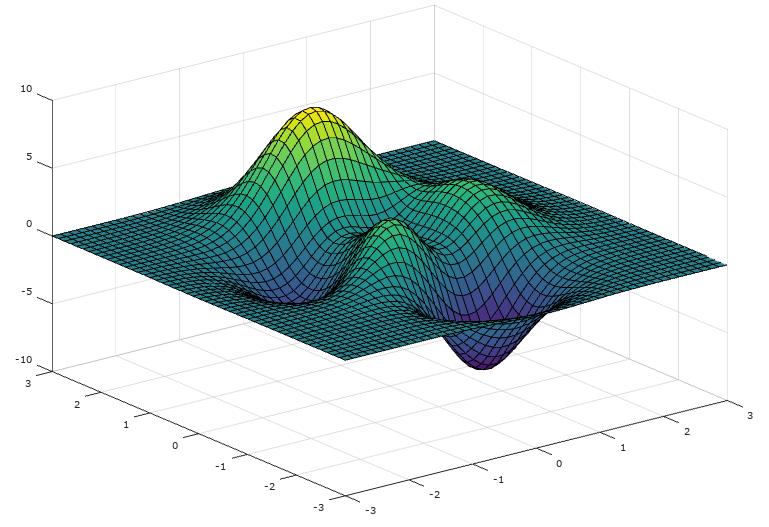

In [40]:
Image('../imagens/05_2d-surface.png')

We see that the cost function may have local minima, and some methods (like _gradient descent_) might get stuck in it and not reach the global minimum. Some models (like linear models) have convex cost functions (only one minimum) and aanlytical or numerical methods to find it. 

For regression problems, it is common to use the mean squared error as the cost function. And for neural networks, the cost function is minimized using the Stochastic Gradient Descent (SGD) method. Let's see this method in action. First, we set up the problem (generate data and instantiate a model):

In [246]:
# Set parameters of the example:
ex_n     = 100
ex_seed  = 6547
ex_xmin  = -1.5
ex_xmax  =  1.5
ex_noise = 0.3

# Generate 3rd-degree polynomial data:
ex_rng   = np.random.default_rng(ex_seed)
ex_x     = rng.uniform(low=ex_xmin, high=ex_xmax, size=ex_n)
ex_y     = 2 * ex_x * (ex_x - 1) * (ex_x + 1) + 2 + rng.normal(scale=0.5, size=n_samples)

# Define model degree and prepare data (compute powers of x):
sgd_degree   = 3
preprocessor = Pipeline([('poly', PolynomialFeatures(sgd_degree, include_bias=False)), ('scal', StandardScaler())])
ex_X   = preprocessor.fit_transform(np.transpose([ex_x]))

# Data points for plotting model's predictions:
x_plot = np.arange(ex_xmin, ex_xmax, 0.1)
X_plot = preprocessor.transform(np.transpose([x_plot]))

# Create linear model that uses the Stochastic Gradient Descent minimization method:
learning_rate = 0.1
sgd_model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(sgd_degree,))])
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True)
#opt = tf.keras.optimizers.RMSprop()
sgd_model.compile(optimizer=opt, loss='mean_squared_error')

rme_list = []

Next, we gradually improve the model's fit using the SGD method. Each time the code below is ran, the model improve its performance (i.e. reduces its mean squared error):

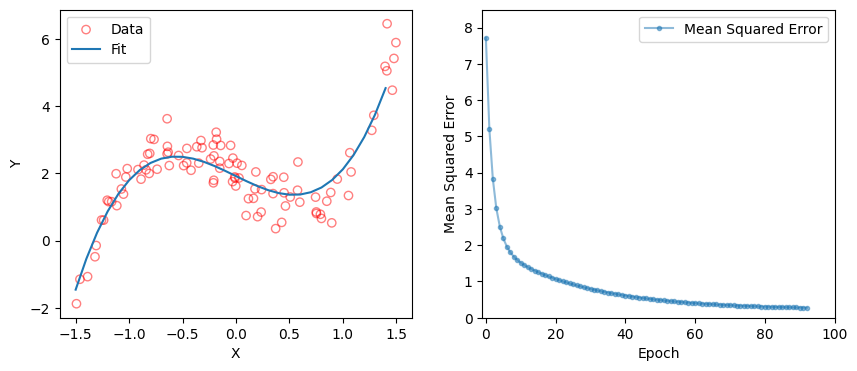

In [280]:
n_epochs = 1
history  = sgd_model.fit(ex_X, ex_y, epochs=n_epochs, batch_size=ex_n, verbose=None)
y_plot = sgd_model.predict(X_plot, verbose=None)[:,0]

rme_list = rme_list + history.history['loss']
pl.figure(figsize=(10, 4))

pl.subplot(1,2,1)
pl.scatter(ex_x, ex_y, edgecolor='r', facecolor='none', alpha=0.5, label='Data')
pl.plot(x_plot, y_plot, label='Fit')
pl.xlabel('X')
pl.ylabel('Y')
pl.legend()

pl.subplot(1,2,2)
pl.plot(rme_list, marker='.', alpha=0.5, label='Mean Squared Error')
pl.xlim([-1, 100])
pl.ylim([0, max(rme_list) * 1.1])
pl.xlabel('Epoch')
pl.ylabel('Mean Squared Error')
pl.legend()
pl.show()

## 3.  Framing the problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 3.1. The big picture

**Our goal:** to create an ML model that takes as input the DOU notices (i.e. its text and, possibly, other relevant data) and outputs a value for each notice associated to its relevance, so the notices can be sorted: the most relevant ones should appear on the top of the list. In this way, a human evaluator could read the notices starting from the most relevant ones, and stop the reading at a point we are confident there are no more relevant notices further down the list.from IPython.display import Image

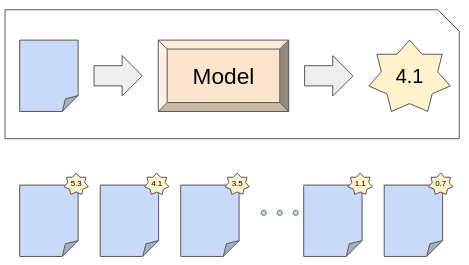

In [3]:
Image(filename='../imagens/10_framing-the-problem_goal-small.png') 

* We have to give to the model examples of notices already labeled according to their relevance as perceived by us (the users). So this is a case of **supervised learning**.
* We want the notices to be sorted, and thus their labels should be ordinal. Although we could adopt [different strategies](https://arxiv.org/abs/2010.06467), we will frame the problem as a **regression task**.
* We will adopt the common strategy of labeling the notices on a relevance scale from 1 (least relevant) to 5 (most relevant). The data we already have annotated contains integer labels only, but **I would recommend using a continuous scale**.

### 3.2. Creating features (vectorizing the text)

Machine learning models can only operate with numbers (they are just complicated mathematical functions that takes as input many numbers and outputs another number). In order for it to work with text, we have to create numbers that represent the text's characteristics we believe to be relevant for the task at hand, that is, we have to **create features that describe the text**. The process of transforming a text into a bunch of numbers is called **vectorization**.

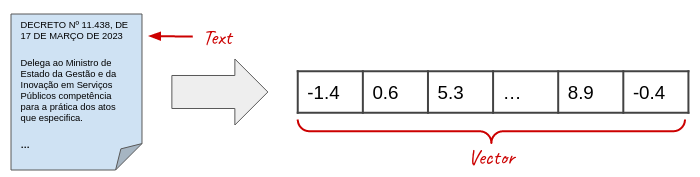

In [7]:
Image(filename='../imagens/20_framing-the-problem_text-vectorization.png') 

#### 3.2.1. Manual features

We could create, one by one, features we believe signal the relevance of a notice. For instance, 
if we are trying to detect nominations to important positions, we could look for: keywords related 
to the position level; surnames that could indicate nepotism; and values of compensations and salaries. E.g.:

_"The Minister of Education appoints GABRIEL JÚLIO DA SILVA as Chief of Staff (DAS-4) 
in the Secretary of Higher Education, with a salary of R$ 6.500,00."_

In [14]:
pd.DataFrame({'nepotism_flag':[0], 'is_das':[1], 'das_level':[4], 'salary':[6500.0]})

,nepotism_flag,is_das,das_level,salary
0,0,1,4,6500.0


Unless the information important for ranking the texts is clearly contained in a few features, this strategy is costly and not very effective.

#### 3.2.2. Bag-of-words

This strategy consists of checking if (or how many times) certain words from a _vocabulary_ appear in the text. The _vocabulary_ can be built from all the texts (_corpus_) in the training set. For instance let's take a simple and small _corpus_ as an example of a training set:

In [52]:
# Take an example of training set:
toy_train_set = ['First, this is the first document in the corpus.', 
                 'This is the second document in the corpus.', 
                 'The corpus is the set made of the first text and the second text and all other texts!']

# Create a vocabulary from it:
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(toy_train_set)
# Show the vocabulary:
vocab = vectorizer.get_feature_names_out()
vocab

array(['all', 'and', 'corpus', 'document', 'first', 'in', 'is', 'made',
       'of', 'other', 'second', 'set', 'text', 'texts', 'the', 'this'],
      dtype=object)

Then, we transform the each text into a vector:

In [53]:
# Count the occurences of each word (actually a token) in each document: 
vectors = vectorizer.transform(toy_train_set)
X_train = pd.DataFrame(data=vectors.toarray(), columns=vocab)
# Show the resulting vectors for each document:
X_train

,all,and,corpus,document,first,in,is,made,of,other,second,set,text,texts,the,this
0,0,0,1,1,2,1,1,0,0,0,0,0,0,0,2,1
1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,2,1
2,1,2,1,0,1,0,1,1,1,1,1,1,2,1,4,0


**Remarks**
* We can **preprocess** the text to reduce the number of unnecessary distinctions (e.g. the case of the words) 
and uninformative words (called _stop words_, such as 'the', 'of', 'this'...). There are many options on what to do at this stage.
* Instead of words, we can identify the presence of other kinds of tokens (e.g. letters, syllables, pairs of adjacent words - called _bigrams_ -, and so on).
* We can make the vectorization binary (i.e. only informs whether the token is present or not in the text).
* We can apply normalizations and weights (such as the Inverse Document Frequency - IDF) to the token counts. 
Check the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html}) for all the options.

#### 3.2.3. Word embedding

The _bag-of-words_ approach treat all words as completely different features, so it is not aware of synonyms or classes of words. 
In the example above, there is nothing to inform the model that 'text', 'texts' and 'documents' mean similar things, so their impact on the output should be similar as well.
Moreover, this representation is inefficient: extracting the vocabulary from a large corpus might result in hundres of thousands of features whose values are mostly zero 
(in a bag-of-words vectorization, a word is represented as a vector full of zeros, apart from a single "1" at just one place: the feature corresponding to counts of that word).
This representation is called _sparse_ and makes the data noisy.

An alternative is to use _word embeddings_: each word is represented by a _dense vector_, and in a way that words with similar meanings have similar vectors, so their effect in the final 
output is also similar. In the example above, instead of representing the words as:

    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 'document'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]  # 'text'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  # 'texts'
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 'first'
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  # 'second'
    
we could have (for a 2D embedding):

In [52]:
embeddings = {
'document': [1, 1.2],
'text':     [1.1, 0.88],
'texts':    [0.9, 0.5],
'first':    [-0.7, 1.4],
'second':   [-0.9, 0.8],
}

The (toy) embeddings above are plot below. We see that words semantically close are also close in the vector space.

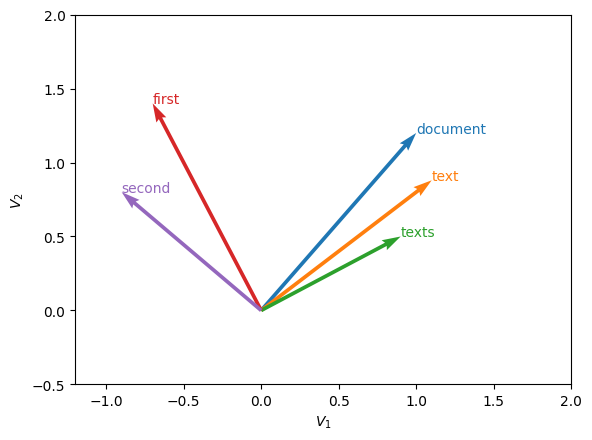

In [62]:
# Plot vectors:
V      = np.array(list(embeddings.values()))
origin = np.zeros((2, len(V))) # origin point
cmap   = pl.get_cmap('tab10')
colors = [cmap(i) for i in range(len(V))]
pl.quiver(*origin, V[:,0], V[:,1], color=colors, angles='xy', scale_units='xy', scale=1)

# Add associated words to vectors: 
names = list(embeddings.keys())
for i, n in enumerate(names):
    pl.text(V[i,0], V[i,1], n, color=cmap(i))

# Format plot:
pl.ylim([-0.5,2]); pl.xlim([-1.2,2])
pl.xlabel('$V_1$'); pl.ylabel('$V_2$')
pl.show()

Word embeddings are used in the context of deep learning by neural network models such as BERT. In this scenario, documents are represented as sequences of word vectors. So the sentence "first text document" would get translated to:

    [[-0.7, 1.4], [1.1, 0.88], [1, 1.2]]

## 4. Ranking texts with bag-of-words

In [ ]:
# Download auxiliary code:
#!git clone https://github.com/hsxavier/xavy.git

In [1]:
# Main analysis imports:
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as pl
from importlib import reload

import xavy.data_retriever as xr
import xavy.utils as xu
import xavy.mltools as ml
import xavy.dataframes as xd

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 4.1. Loading annotated data

We will load DOU notices from section 1 (normative acts) that were annotated in terms of relevance by civil servants working on government oversight between 2020 and 2021. The notices were scraped from the official DOU website: <https://www.in.gov.br/leiturajornal>
* These notices were annotated in a scale from 1 (least relevant) to  5 (most relevant).
* High relevance notices are rare in DOU. As a strategy to increase the number of instances in this category, we will also use notices that were published between 2019 and 2020 on a specialized news service as examples of relevance level 5 notices.
* All the data aboved was concatenated into a single CSV file.
* Some processing was already done to the notices' texts: removing a common standard disclaimer referring to "versão certificada" (certified version).

In [3]:
# Load annotated dataset:
file_name = 'annotated_DOU_notices_n_BRO'
xr.sync_remote_zipped_files('https://nuvem.ceweb.br/s/XzSkEmkp4FjCErP/download/{}.zip'.format(file_name), './data/', keep_zip_dir=False)
annotated_notices_df = pd.read_csv('./data/{}.csv'.format(file_name))

!! Found more than one matching file or folder.
['./data/annotated_DOU_notices_n_BRO.zip', './data/annotated_DOU_notices_n_BRO.csv']
Found a local file, skip download.


Let's see how the data looks like:

In [4]:
# Example of annotated data:
annotated_notices_df.sample(5)

,relevancia,identifica,secao,edicao,pagina,data_pub,orgao,ementa,resumo,fulltext,assina,cargo,url,url_certificado,data_registro
1200,3,"LEI Nº 14.039, DE 17 DE AGOSTO DE 2020",1,158,5,2020-08-18,Atos do Poder Legislativo,"Altera a Lei nº 8.906, de 4 de julho de 1994 (...",O P R E S I D E N T E D A R E P Ú B L I C A Fa...,O P R E S I D E N T E D A R E P Ú B L I C A ...,NaN,NaN,http://www.in.gov.br/web/dou/-/lei-n-14.039-de...,http://pesquisa.in.gov.br/imprensa/jsp/visuali...,2020-08-19 04:07:40.554405
2615,2,"PORTARIA GM Nº 4.556, DE 15 DE Março DE 2021",1,51,4,2021-03-17,"Ministério da Ciência, Tecnologia e Inovações/...",Cria a Rede Nacional de Métodos Alternativos a...,Art. 1º Fica criada a Rede Nacional de Métodos...,"O MINISTRO DE ESTADO DA CIÊNCIA, TECNOLOGIA ...",LEONIDAS DE ARAÚJO MEDEIROS JÚNIOR,NaN,http://www.in.gov.br/web/dou/-/portaria-gm-n-4...,http://pesquisa.in.gov.br/imprensa/jsp/visuali...,2021-03-18 04:01:37.250238
713,2,"PORTARIA AUDIT/FNDE Nº 1, DE 20 DE AGOSTO DE 2021",1,159,261,2021-08-23,Ministério da Educação/Fundo Nacional de Desen...,Institui o Programa de Gestão e Melhoria de Qu...,Art. 1º Instituir o Programa de Gestão e Melho...,O AUDITOR-CHEFE DO FUNDO NACIONAL DE DESENVO...,VICTOR LEANDRO FREITAS DE JESUS,NaN,http://www.in.gov.br/web/dou/-/portaria-audit/...,http://pesquisa.in.gov.br/imprensa/jsp/visuali...,2021-08-24 04:02:38.253161
1912,3,"RESOLUÇÃO BCB Nº 37, DE 4 DE NOVEMBRO DE 2020",1,212,39,2020-11-06,Ministério da Economia/Banco Central do Brasil...,Institui a Política de Transparência do Banco ...,Art. 1º Fica instituída a Política de Transpar...,"O Comitê de Governança, Riscos e Controles d...",ROBERTO DE OLIVEIRA CAMPOS NETO | MAURICIO COS...,"Presidente | Diretor de Relacionamento, Cidada...",http://www.in.gov.br/web/dou/-/resolucao-bcb-n...,http://pesquisa.in.gov.br/imprensa/jsp/visuali...,2020-11-07 04:03:19.350305
3488,1,"RESOLUÇÃO-RE nº 866, DE 25 DE MARÇO DE 2020",1,61,109,2020-03-30,Ministério da Saúde/Agência Nacional de Vigilâ...,NaN,O Gerente-Geral de Inspeção e Fiscalização San...,O Gerente-Geral de Inspeção e Fiscalização San...,RONALDO LUCIO PONCIANO GOMES,NaN,http://www.in.gov.br/web/dou/-/resolucao-re-n-...,http://pesquisa.in.gov.br/imprensa/jsp/visuali...,2020-04-01 04:01:09.375022


For each published DOU notice (row), we have the following information (columns):
1. **relevancia** - the relevance, annotated by the civil servants;
2. **identifica** - the title of the notice;
3. **secao** - the DOU section (in this case, always 1);
4. **edicao** - the DOU edition (a sequential number for each year), which can be followed by a letter in case of an extraordinary edition;
5. **pagina** - the page number (in the PDF version) where the notice was published;
6. **data_pub** - the date of publication;
7. **orgao** - the government organization responsible for the notice (in a standardized, hierarchical structure);
8. **ementa** - the abstract of the notice (sometimes it does not exist);
9. **resumo** - a representative excerpt the scraping system extracted;
10. **fulltext** - the body of the notice (main text, including the signature);
11. **assina** - the servant or authority that signed the notice (there might be more than one person, separated by "|", or none);
12. **cargo** - the position occupied by who signed the notice (it might be empty);
13. **url** - the link to the online (HTML) version of the notice; 
14. **url_certificado** - link to the PDF version of the page containing the notice;
15. **data_registro** - Date and time when the notice was captured by the scraping system.

For ranking the notices, there is valuable information in the fields: identifica, edicao, orgao, ementa, fulltext, assina, and cargo.

### 4.2. Dataset split

Our model is likely to be updated regularly (as new notices get annotated), so we need to guarantee that the instances do not switch datasets when we again split the dataset after adding new data. 
Since each DOU notice is uniquely identified by its URL, we can use the string hash function to split the dataset:

In [5]:
# Randomly split dataset:
build_raw, test_raw = train_test_split_by_string(annotated_notices_df, 0.15, 'url', 'http://www.in.gov.br/web/dou/-/')
train_raw, val_raw  = train_test_split_by_string(build_raw, 0.17, 'url', 'http://www.in.gov.br/')

In [6]:
# Check the amount of each class in each set:
n_ex_by_relevancia = pd.DataFrame()
n_ex_by_relevancia['train'] = train_raw.relevancia.value_counts()
n_ex_by_relevancia['val'] = val_raw.relevancia.value_counts()
n_ex_by_relevancia['test'] = test_raw.relevancia.value_counts()
assert n_ex_by_relevancia.isna().any().any() == False, 'Some set has missing classes'
n_ex_by_relevancia.sort_index()

,train,val,test
1,1760,375,389
2,831,153,169
3,516,96,102
4,426,82,79
5,463,88,102


### 4.3. Preparing the texts

In [7]:
from sklearn.pipeline import Pipeline

# Load custom-made module:
import dou_sorter_common_functions as do

First, we want to select from the raw data the information that is useful for ranking notices; adding useless data to the model input is like adding noise. 
Our intuition, along with insights gained from exploring the data and studying the performance of the model on the validation set, made us create a transformer
(stored in [./dou_sorter_common_functions.py](./dou_sorter_common_functions.py)) that selects and organizes the useful information from the raw data. We instantiate it below:

In [8]:
# Instantiate a preprocessing transformation for DOU data:
textual_cols  = ['tit_org_ementa_text']
dou_extractor = do.PreprocessDOU(['relevancia', 'tipo_edicao'] + textual_cols, 'xxnullxx')

This transformer does X things:
* selects only columns that containg useful information, dropping the rest (the signee and her/his position is also present in the 'fulltext' column, so they are not selected);
* from the notice title, 'identifica', it selects only the notice type (decree, law, etc);
* from the organization column, 'orgao', it replaces the '/' for whitespaces;
* these two fields are concatenated into a single text (separated by spaces), along with the abstract ('ementa') and body text ('fulltext'); and
* missing data in any of the concataning fields above are filled with 'xxnullxx'.

Below we show the output of our transformer:

In [9]:
# Check the output of the preprocessor:
examples_df = train_raw.sample(5, random_state=682)
extracted_example_df = dou_extractor.transform(examples_df)

# Example of preprocessor output:
display(extracted_example_df)
print(extracted_example_df['tit_org_ementa_text'].iloc[0])

,relevancia,tipo_edicao,tit_org_ementa_text
962,2,Ordinária,portaria Ministério da Economia Secretaria Esp...
4433,2,Ordinária,decreto Atos do Poder Executivo Altera o Decre...
1118,4,Ordinária,decreto Atos do Poder Executivo Dispõe sobre o...
5588,5,Ordinária,resolução Ministério da Infraestrutura Agência...
3108,1,Extra,resolução-re Ministério da Saúde Agência Nacio...


portaria Ministério da Economia Secretaria Especial de Previdência e Trabalho Altera o prazo para comprovação à Secretaria Especial de Previdência e Trabalho do cumprimento de parâmetros gerais relativos aos Regimes Próprios de Previdência Social dos Estados, do Distrito Federal e dos Municípios.   O SECRETÁRIO ESPECIAL DE PREVIDÊNCIA E TRABALHO DO MINISTÉRIO DA ECONOMIA, no uso das atribuições que lhe conferem a alínea "a" do inciso II do art. 71 e o art. 180 do Anexo I ao Decreto nº 9.745, de 08 de abril de 2019, e o inciso VII do art. 1º da Portaria ME nº 117, de 26 de março de 2019, e tendo em vista o disposto no caput e nos §§ 1º a 5º do art. 9º da Emenda Constitucional nº 103, de 12 de novembro de 2019, nos incisos I e III do art. 1º e nos arts. 2º, 3º e 9º da Lei nº 9.717, de 27 de novembro de 1998, nos incisos II, VI e XIV do art. 5º da Portaria MPS nº 204, de 10 de julho de 2018, resolve: Art. 1º Fica prorrogado até 30 de setembro de 2020, exclusivamente para os fins de emissã

Next, we do some standard text preprocessing on the cancatenated textual data. This is done by a second transformer, also stored in [./dou_sorter_common_functions.py](./dou_sorter_common_functions.py).

This second transformer has the following options:
* set the whole text to lower case;
* remove punctuation;
* transform values in R$ into tokens representing logarithmic bins;
* remove a list of words called 'stopwords';
* remove the suffix of the words (stemming);
* remove accents;
* remove numbers and other special characters;
* standardize position codes (e.g. DAS-101.4 and DAS201.4 --> DAS4).

In [10]:
# List of words that do not carry any important information:
stopwords = ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais',
                 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também',
                 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse',
                 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles',
                 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus',
                 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles',
                 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava',
                 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera',
                 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei',
                 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos',
                 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos',
                 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos',
                 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

We used fine-tuning over the validation set to choose the best-performing transformations (these are dependent on other hyperparameters of the model):

In [11]:
# Instantiate a preprocessing transformation for text columns in a DataFrame:
text_preprocessor = do.PreProcessText(lowercase=False, remove_punctuation=True, value_tokens=True, stopwords=stopwords, stemmer=None, 
                                      strip_accents=False, only_letters=False, keep_cash=True, cargo_tokens=True, text_cols=textual_cols)

Below we show the result from applying the text preprocessor to the notices:

In [12]:
# Preprocess the text:
preprocessed_example_df = text_preprocessor.transform(extracted_example_df)

# Example of preprocessor output:
display(preprocessed_example_df)
print(preprocessed_example_df['tit_org_ementa_text'].iloc[0])

,relevancia,tipo_edicao,tit_org_ementa_text
962,2,Ordinária,portaria Ministério Economia Secretaria Especi...
4433,2,Ordinária,decreto Atos Poder Executivo Altera Decreto nº...
1118,4,Ordinária,decreto Atos Poder Executivo Dispõe sobre horá...
5588,5,Ordinária,resolução Ministério Infraestrutura Agência Na...
3108,1,Extra,resoluçãore Ministério Saúde Agência Nacional ...


portaria Ministério Economia Secretaria Especial Previdência Trabalho Altera prazo comprovação Secretaria Especial Previdência Trabalho cumprimento parâmetros gerais relativos Regimes Próprios Previdência Social Estados Distrito Federal Municípios O SECRETÁRIO ESPECIAL DE PREVIDÊNCIA E TRABALHO DO MINISTÉRIO DA ECONOMIA uso atribuições conferem alínea inciso II art 71 art 180 Anexo I Decreto nº 9745 08 abril 2019 inciso VII art 1º Portaria ME nº 117 26 março 2019 tendo vista disposto caput §§ 1º 5º art 9º Emenda Constitucional nº 103 12 novembro 2019 incisos I III art 1º arts 2º 3º 9º Lei nº 9717 27 novembro 1998 incisos II VI XIV art 5º Portaria MPS nº 204 10 julho 2018 resolve Art 1º Fica prorrogado 30 setembro 2020 exclusivamente fins emissão Certificado Regularidade Previdenciária trata inciso IV art 9º Lei nº 9717 27 novembro 1998 prazo comprovação Secretaria Especial Previdência Trabalho medidas tratam alíneas b inciso I art 1º Portaria nº SEPRT 1348 3 dezembro 2019 Art 2º Ficam 

We can put these two transformers into a single pipeline:

In [13]:
# Create a proprocessing pipeline:
preprocessor = Pipeline([('dou', dou_extractor), ('pretext', text_preprocessor)])

Here is the result, after applying the pipeline to the raw train and validation data:

In [ ]:
# Create a CV set and pre-process it:
train_val_concat = pd.concat([train_raw, val_raw], sort=False)
proc_train_val   = preprocessor.transform(train_val_concat)

In [63]:
w = (1 / train_raw['relevancia'].value_counts())
w = w / w[1]

In [64]:
# Add sample weight: we care that the most relevant notices are identified:
proc_train_val['weight'] = proc_train_val['relevancia'].map(w.to_dict()) # {1:1, 2:2, 3:4, 4:8, 5:16}
# Separate train and validation samples:
proc_train = proc_train_val[:len(train_raw)]
proc_val   = proc_train_val[len(train_raw):]
# Show examples
proc_train_val.head()

,relevancia,tipo_edicao,tit_org_ementa_text,weight
1,1,Ordinária,portaria seimast Ministério Ciência Tecnologia...,1.000000
2,2,Ordinária,portaria Ministério Infraestrutura Gabinete Mi...,2.117930
3,3,Ordinária,resolução ccfgts Ministério Trabalho Previdênc...,3.410853
4,4,Ordinária,lei Atos Poder Legislativo Altera Lei nº 12212...,4.131455
5,4,Ordinária,decreto Atos Poder Executivo Cria Empresa Bras...,4.131455


### 4.4. Building and fine-tuning the model 

In [40]:
# For building the model:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

# For fine-tuning:
from sklearn.metrics import make_scorer
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

# For evaluating:
import dou_model_eval as ev

In [41]:
def ndcg_metric(y_true, y_pred):
    return ndcg_score(np.array([y_true]), np.array([y_pred]))

In [19]:
rank_scorer = make_scorer(ev.cum_recall_metric, greater_is_better=True)
ndcg_scorer = make_scorer(ndcg_metric, greater_is_better=True)

After preprocessing text, we have to vectorize the text and transform the edition type column in a numerical information. This is done by the transformer `processor` below.

In [20]:
# Build vectorizer and encoder:
vectorizer    = TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,2), max_df=1.0, min_df=1, norm=None, use_idf=False)
encoder_extra = OneHotEncoder(drop='first')
processor     = ColumnTransformer([('vec',   vectorizer, textual_cols[0]), ('extra', encoder_extra, ['tipo_edicao'])])

Let's see the effect of it on a small piece of data: 

In [21]:
# Get the vocabulary and check how many distinct types of editions there are:
dump = processor.fit(proc_train)
# Vectorize the text and encode the edition type:
X_example = processor.transform(proc_train_val.head())

# Show the results for 5 instances:
feature_names = processor.get_feature_names_out()
X_example_df = pd.DataFrame(data=X_example.toarray(), columns=feature_names)
X_example_df.sort_values(0, axis=1, ascending=False)

,extra__tipo_edicao_Ordinária,vec__disposto Portaria,vec__comissão,vec__2018 entrará,vec__conformidade,vec__129,vec__publicada Diário,vec__informação MAST,vec__129 12,vec__maio 2021,...,vec__LCVM,vec__LCVMs serem,vec__LCVMs documentação,vec__LCVMs Para,vec__LCVMs Marca,vec__LCVMs Empresa,vec__LCVMs,vec__LCVM ciclomotores,vec__LCVM Empresa,vec__aplicação códigos
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that each instance is turned into a very long vector. One column tells whether the edition is ordinary of not, and the rest tell wether a given word appears in the text.

The next and last part of the model is to add a regressor to it:

In [22]:
# Add a regressor to the end of the pipeline:
regressor     = Ridge(alpha=300)
model         = Pipeline([('proc', processor), ('fit', regressor)])

Now we will perform the **fine tuning using grid search (or randomized search)**. First, let's plan our search by selecting the hyperparameters we want to test 
and the search method (grid or randomized). Grid search is helpful for understanding how the bias and variance of the model are affected by the hyperparameters, 
and it may be helful for a small search. For a large number of parameter combinations, random search is recommended. 

In [23]:
param_grid = {'fit__alpha': [1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5],
              #'proc__vec__use_idf': [False, True],
              #'proc__vec__min_df': [1,3,10, 30, 100, 300],
              #'proc__vec__lowercase': [False, True],
              #'proc__vec__binary': [False, True],
              #'proc__vec__norm': [None, 'l1', 'l2'],
              #'proc__vec__ngram_range': [(1,1), (1,2)]
             }

# Do a Grid or Randomized search with fixed validation set:
test_fold = np.zeros(len(train_val_concat)).astype(int)
test_fold[:len(train_raw)] = -1
ps = PredefinedSplit(test_fold)
grid = GridSearchCV(model, param_grid, cv=ps, scoring=ndcg_scorer, return_train_score=True, n_jobs=7)
#grid = RandomizedSearchCV(model, param_grid, cv=ps, scoring=rank_scorer, return_train_score=True, n_jobs=7, n_iter=100)

We could use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) in the grid search (it would give us a more precise performance estimation) but it would be slower.

Now let's run the search!

In [69]:
# Run the hyper parameter search:
dump = grid.fit(proc_train_val, proc_train_val['relevancia'].values, fit__sample_weight=proc_train_val['weight'])

print('Best score:', grid.best_score_)
print('Params:', grid.best_params_)

Best score: 0.977525175377959
Params: {'fit__alpha': 300.0}


The table below shows the results of the hyper parameter trials:

In [70]:
ml.searchCV_table(grid).head(5)

,mean_fit_time,std_fit_time,param_fit__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
3,19.537201,0.0,300.0,0.977525,0.0,0.999152,0.0
2,21.829793,0.0,100.0,0.977100,0.0,0.999785,0.0
4,19.193033,0.0,1000.0,0.976687,0.0,0.997105,0.0
1,26.408721,0.0,30.0,0.976121,0.0,0.999948,0.0
0,30.148078,0.0,10.0,0.975267,0.0,0.999990,0.0


The plot below helps us see when the model transitions from a regime dominated by bias (when underfitting) to a regime dominated by variance (when overfitting), 
and shows the sweet spot, where unseen data is best predicted: 

/home/hxavier/prog/my-python/xavy/mltools.py:2009: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


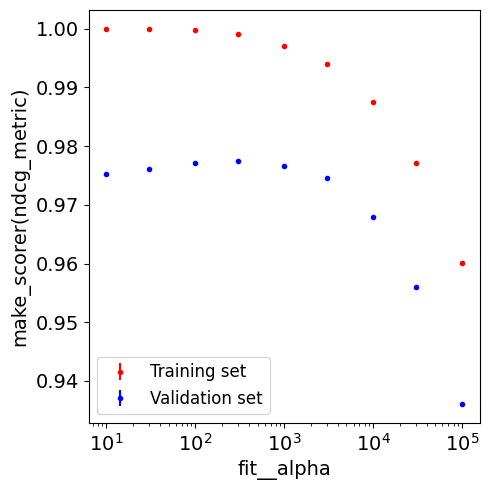

In [72]:
ml.plot_pars_scores(grid)

### 4.5. Evaluating the model

We will use the hyperparameters of the best fit to create a model and fit it to the training data. In this tutorial, the hyperparameters set when first creating the model were already chosen in this fashion. 
Therefore, we just fit it again to the training data and check that the performance is the same as before:

In [157]:
# Fit the best model to the training data:
dump = model.fit(proc_train, proc_train['relevancia'], fit__sample_weight=proc_train['weight'])
# Predict on the validation data:
pred_val = model.predict(proc_val)
# Check the metric is correct (PS: nDCG formula requires lowest relevance to be 0):
ndcg_metric(proc_val['relevancia'] - 1, pred_val)

0.9775242907579917

The metric above is hard to interpret. Below we see how the predicted relevance in distributed for notices with different true relevance.

The box extends from the Q1 to Q3 quartile values of the data,
with a line at the median (Q2). The whiskers extend from the edges
of box to show the range of the data. By default, they extend no more than
`1.5 * IQR (IQR = Q3 - Q1)` from the edges of the box, ending at the farthest
data point within that interval. Outliers are plotted as separate dots.

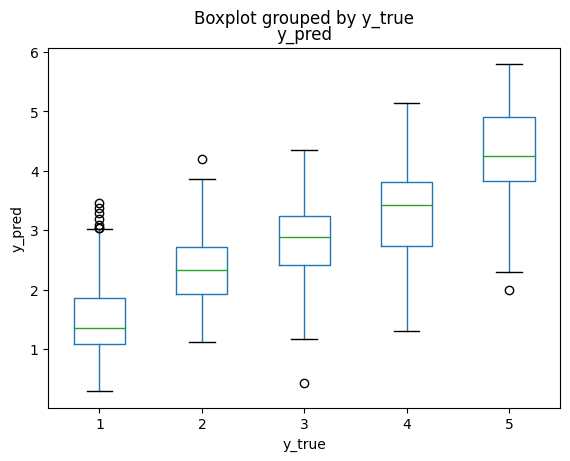

In [158]:
# Box plot of the distribution of predicted relevances per true relevance:
y_pred_true_df = pd.DataFrame({'y_pred':pred_val, 'y_true': proc_val['relevancia'].values}, index=proc_val.index)
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
pl.ylabel('y_pred')
pl.show()

Another way of interpret the results is to plot the fraction of notices with true relevance 4 or 5 that gets selected (recall) as we include in our selection,
in the order they were ranked, more and more notices (this is called Recall@$k$, where $k$ is the number of notices selected). 
The plot below compares such metric with the ones obtained when the notices are randomly ordered and when 
they are perfectly ordered.

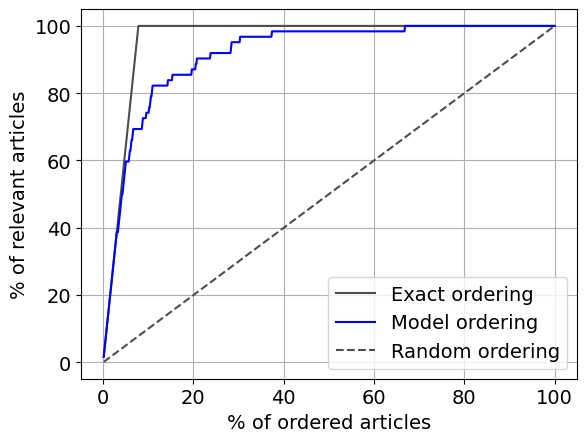

In [165]:
# Hard-coded distribution of relevances "in the wild" (as seen daily on DOU):
original_relevance_dist = pd.Series([988,160,112,69,68], index=[1,2,3,4,5], name='orig_counts')
original_relevance_dist = original_relevance_dist / original_relevance_dist.sum()

# Compute weights for sampling validation data as data in the wild:
wild_dist_weights = original_relevance_dist / proc_val['relevancia'].value_counts(normalize=True)
wild_dist_weights.name = 'wild_weights'
# Assign weights to instances:
wild_weights = proc_val.join(wild_dist_weights, on='relevancia')['wild_weights']

# Sample data as seen in the wild:
wild_val_df = proc_val.sample(len(proc_val), replace=True, weights=wild_weights, random_state=2891)
# Predict reelvance:
pred_wild_val = model.predict(wild_val_df)
# Plot:
ev.plot_fancy_recall_curve(wild_val_df['relevancia'].values, pred_wild_val, 'b')

## 5. Ranking texts with deep learning

In [ ]:
# Define o modelo em questão:
model_name = 'neuralmind/bert-base-portuguese-cased'
# Carregando:
tokenizer  = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model      = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)